In [ ]:
!nvidia-smi

Tue Jul 22 19:25:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
!pip show torch

Name: torch
Version: 2.6.0+cu124
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.11/dist-packages
Requires: filelock, fsspec, jinja2, networkx, nvidia-cublas-cu12, nvidia-cuda-cupti-cu12, nvidia-cuda-nvrtc-cu12, nvidia-cuda-runtime-cu12, nvidia-cudnn-cu12, nvidia-cufft-cu12, nvidia-curand-cu12, nvidia-cusolver-cu12, nvidia-cusparse-cu12, nvidia-cusparselt-cu12, nvidia-nccl-cu12, nvidia-nvjitlink-cu12, nvidia-nvtx-cu12, sympy, triton, typing-extensions
Required-by: accelerate, fastai, peft, sentence-transformers, timm, torchaudio, torchdata, torchvision


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from dataclasses import dataclass
from tqdm import trange, tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import TransformerEncoder, TransformerEncoderLayer

## Data

In [4]:
# data = generate_ar_data(n_series=1, timesteps=2500, trend=0, seasonality=4, noise=0.1, level=1)
historical_data = pd.read_csv("zcyc_ranges.csv", skiprows=1, sep=";")

In [5]:
historical_data = historical_data.drop(columns="tradetime")

In [6]:
historical_data["tradedate"] = pd.to_datetime(historical_data["tradedate"], format="%d.%m.%Y")
historical_data = historical_data.set_index("tradedate")

In [7]:
historical_data = historical_data.apply(lambda x: x.str.replace(',', '.')).astype(float) / 100

<Axes: xlabel='tradedate'>

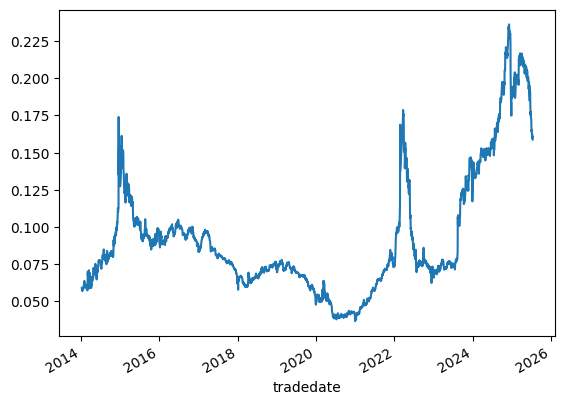

In [8]:
historical_data["period_0.25"].plot()

In [9]:
historical_data_train = np.log(historical_data[:"2024-01-01"]).diff().dropna()

In [10]:
std = historical_data_train.std()
mean = historical_data_train.mean()

In [11]:
historical_data_train = (historical_data_train - mean) / std

<Axes: >

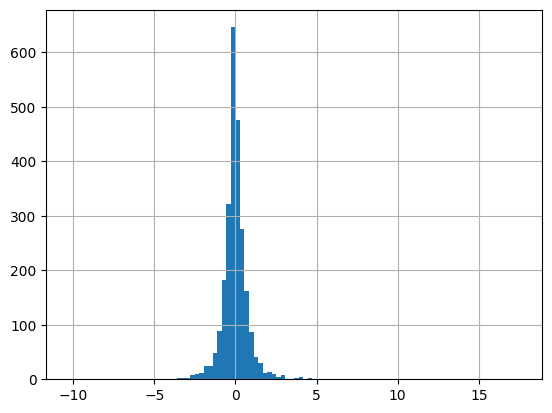

In [12]:
historical_data_train["period_0.25"].hist(bins=100)

In [25]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

In [182]:
class EmbeddingNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1 if num_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x):
        """Returns final embedding only"""
        lstm_out, _ = self.lstm(x)
        lstm_out = self.layer_norm(lstm_out)
        embedding = self.linear(lstm_out[:, -1, :])  # Take last timestep only
        return embedding

    def lstm_forward(self, x):
        """Returns full LSTM sequence outputs"""
        lstm_out, _ = self.lstm(x)
        return self.layer_norm(lstm_out)  # [batch_size, seq_len, hidden_dim]

class RecoveryNetwork(nn.Module):
    def __init__(self, hidden_dim, output_dim, num_layers=3):
        """Improved recovery network with residual connections"""
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers,
                           batch_first=True,
                           dropout=0.1 if num_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, output_dim)
        )

    def forward(self, h, seq_len=None):  # Make seq_len optional
        # Handle both cases:
        # - 2D input [batch_size, hidden_dim] (if seq_len provided)
        # - 3D input [batch_size, seq_len, hidden_dim] (if seq_len None)
        if h.dim() == 2 and seq_len is not None:
            h = h.unsqueeze(1).expand(-1, seq_len, -1)

        lstm_out, _ = self.lstm(h)
        lstm_out = self.layer_norm(lstm_out)
        recovered = self.linear(lstm_out)
        return recovered

class TransformerGenerator(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, num_heads=4, num_layers=3):
        super().__init__()
        self.latent_proj = nn.Linear(latent_dim, hidden_dim)

        encoder_layers = TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers)
        self.output_proj = nn.Linear(hidden_dim, output_dim)  # Ensure output_dim matches hidden_dim

        # Learnable positional embeddings
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, hidden_dim))

    def forward(self, z, seq_len):
        batch_size = z.size(0)

        # Project latent vectors
        z_proj = self.latent_proj(z).unsqueeze(1)  # [batch, 1, hidden_dim]
        z_seq = z_proj.expand(-1, seq_len, -1)     # [batch, seq_len, hidden_dim]

        # Add positional embeddings
        if seq_len > self.pos_embedding.size(1):
            # Dynamically expand positional embeddings if needed
            new_pos_embed = F.interpolate(
                self.pos_embedding.permute(0, 2, 1),
                size=seq_len,
                mode='linear'
            ).permute(0, 2, 1)
            z_seq = z_seq + new_pos_embed
        else:
            z_seq = z_seq + self.pos_embedding[:, :seq_len, :]

        # Transformer processing
        z_seq = z_seq.transpose(0, 1)  # [seq_len, batch, hidden_dim]
        transformer_out = self.transformer(z_seq)
        transformer_out = transformer_out.transpose(0, 1)  # [batch, seq_len, hidden_dim]

        return self.output_proj(transformer_out)  # [batch, seq_len, output_dim]

class TransformerDiscriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads=4, num_layers=3):
        super().__init__()
        # Input projection ensures correct dimension
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.LeakyReLU(0.2)
        )

        encoder_layers = TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=0.1,
            activation='gelu'
        )
        self.transformer = TransformerEncoder(encoder_layers, num_layers)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim//2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Ensure input dimension matches
        x_proj = self.input_proj(x)  # [batch, seq_len, hidden_dim]
        x_proj = x_proj.transpose(0, 1)  # [seq_len, batch, hidden_dim]

        transformer_out = self.transformer(x_proj)
        # Use mean pooling across sequence
        pooled = transformer_out.mean(dim=0)  # [batch, hidden_dim]
        return self.classifier(pooled)  # [batch, 1]

class SupervisorNetwork(nn.Module):
    def __init__(self, hidden_dim, num_layers=2):
        """Improved supervisor with skip connections"""
        super().__init__()
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True, dropout=0.1 if num_layers > 1 else 0)
        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.linear = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 2),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim * 2, hidden_dim)
        )

    def forward(self, h):
        lstm_out, _ = self.lstm(h)
        lstm_out = self.layer_norm(lstm_out)
        next_h = self.linear(lstm_out)
        return next_h + h  # Skip connection


In [236]:
class TimeGAN(nn.Module):  # Made it a proper nn.Module
    def __init__(self, input_dim, hidden_dim=64, latent_dim=32, seq_len=24,
                 num_heads=4, transformer_layers=3, device=None):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')

        # Initialize networks with proper device placement
        self.embedder = EmbeddingNetwork(input_dim, hidden_dim).to(self.device)
        self.recovery = RecoveryNetwork(hidden_dim, input_dim).to(self.device)
        self.generator = TransformerGenerator(latent_dim, hidden_dim, hidden_dim,
                                           num_heads, transformer_layers).to(self.device)
        self.discriminator = TransformerDiscriminator(hidden_dim, hidden_dim,
                                                    num_heads, transformer_layers).to(self.device)
        self.supervisor = SupervisorNetwork(hidden_dim).to(self.device)

        # Initialize weights
        self._initialize_weights()

        # Optimizers
        self.autoencoder_optim = optim.AdamW(
            list(self.embedder.parameters()) + list(self.recovery.parameters()),
            fused=True,
            lr=1e-3,
            weight_decay=1e-5
        )
        self.generator_optim = optim.AdamW(
            list(self.generator.parameters()) + list(self.supervisor.parameters()),
            fused=True,
            lr=1e-3,
            weight_decay=1e-5
        )
        self.discriminator_optim = optim.AdamW(
            self.discriminator.parameters(),
            fused=True,
            lr=1e-4,
            weight_decay=1e-5  # Lower lr for discriminator
        )

        # Learning rate schedulers
        self.autoencoder_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.autoencoder_optim, patience=5, factor=0.5
        )
        self.generator_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.generator_optim, patience=5, factor=0.5
        )

        # Loss functions
        self.mse_loss = nn.MSELoss()
        self.bce_loss = nn.BCEWithLogitsLoss()

        # Loss history tracking
        self.loss_history = {
            'autoencoder': [],
            'supervisor': [],
            'generator': [],
            'discriminator': []
        }

    def _initialize_weights(self):
        """Proper weight initialization for all components"""
        def _init_weights(m):
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_uniform_(param.data)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param.data)
                    elif 'bias' in name:
                        nn.init.zeros_(param.data)
                        # Set forget gate bias to 1
                        if len(param.shape) >= 1:
                            param.data[param.shape[0] // 4 : param.shape[0] // 2].fill_(1.0)

        for net in [self.embedder, self.recovery, self.generator,
                   self.discriminator, self.supervisor]:
            net.apply(_init_weights)

    def train_autoencoder(self, real_data):
        """Training for embedding and recovery networks"""
        self.autoencoder_optim.zero_grad()

        # Forward pass
        h = self.embedder(real_data)  # [batch, hidden_dim]
        recovered_data = self.recovery(h, self.seq_len)  # [batch, seq_len, input_dim]

        # Loss calculation
        loss = self.mse_loss(recovered_data, real_data)

        # Backward pass with gradient clipping
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.embedder.parameters()) + list(self.recovery.parameters()),
            max_norm=1.0
        )
        self.autoencoder_optim.step()

        # Record loss
        self.loss_history['autoencoder'].append(loss.item())
        return loss.item()

    def train_supervisor(self, real_data):
        """Training for supervisor network"""
        self.generator_optim.zero_grad()

        # Get hidden representation - now keeping sequence dimension
        h = self.embedder.lstm_forward(real_data)  # [batch_size, seq_len, hidden_dim]

        # Predict next hidden state
        next_h = self.supervisor(h)  # [batch_size, seq_len, hidden_dim]

        # Loss calculation (predict next step)
        loss = self.mse_loss(next_h[:, 1:, :], h[:, :-1, :])

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            self.supervisor.parameters(),
            max_norm=1.0
        )
        self.generator_optim.step()

        # Record loss
        self.loss_history['supervisor'].append(loss.item())
        return loss.item()

    def train_generator(self, real_data, batch_size):
        """Joint training for generator and supervisor"""
        self.generator_optim.zero_grad()

        # Generate synthetic hidden states
        z = torch.randn(batch_size, self.latent_dim, device=self.device)
        synthetic_h = self.generator(z, self.seq_len)  # [batch_size, seq_len, hidden_dim]

        # 1. Supervised loss (temporal consistency)
        next_synthetic_h = self.supervisor(synthetic_h)  # [batch_size, seq_len, hidden_dim]
        supervised_loss = self.mse_loss(
            next_synthetic_h[:, 1:, :],  # Predict next step
            synthetic_h[:, :-1, :]       # From previous step
        )

        # 2. Feature matching loss
        with torch.no_grad():
            # Get full sequence of real hidden states
            real_h = self.embedder.lstm_forward(real_data)  # [batch_size, seq_len, hidden_dim]

        # Compare means across time dimension
        synth_mean = synthetic_h.mean(dim=1)
        real_mean = real_h.mean(dim=1)

        feature_loss = self.mse_loss(
            synth_mean[:real_h.size()[0], :],  # [batch_size, hidden_dim]
            real_mean        # [batch_size, hidden_dim]
        )

        # 3. Adversarial loss
        synthetic_probs = self.discriminator(synthetic_h)  # [batch_size, 1]
        adversarial_loss = self.bce_loss(
            synthetic_probs,
            torch.ones_like(synthetic_probs)
        )

        # 4. Embedding space loss (compare full sequences)
        embedding_loss = self.mse_loss(
            synthetic_h[:real_h.size()[0], :, :],  # [batch_size, seq_len, hidden_dim]
            real_h       # [batch_size, seq_len, hidden_dim]
        )

        # Weighted total loss
        total_loss = (
            1.0 * supervised_loss +
            0.5 * feature_loss +
            1.0 * adversarial_loss +
            0.2 * embedding_loss
        )

        # Backward pass
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(
            list(self.generator.parameters()) + list(self.supervisor.parameters()),
            max_norm=1.0
        )
        self.generator_optim.step()

        return total_loss.item()

    def train_discriminator(self, real_data, batch_size):
        self.discriminator_optim.zero_grad()

        # Real data
        with torch.no_grad():
            real_h = self.embedder.lstm_forward(real_data)

        # Synthetic data
        with torch.no_grad():
            z = torch.randn(batch_size, self.latent_dim, device=self.device)
            synthetic_h = self.generator(z, self.seq_len)

        # Standard discriminator loss without gradient penalty
        real_probs = self.discriminator(real_h)
        synthetic_probs = self.discriminator(synthetic_h.detach())

        real_loss = self.bce_loss(real_probs, torch.ones_like(real_probs))
        synthetic_loss = self.bce_loss(synthetic_probs, torch.zeros_like(synthetic_probs))

        # Spectral normalization alternative
        total_loss = (real_loss + synthetic_loss) / 2
        total_loss.backward()

        torch.nn.utils.clip_grad_norm_(self.discriminator.parameters(), max_norm=1.0)
        self.discriminator_optim.step()

        return total_loss.item()

    def generate_samples(self, num_samples, return_latent=False):
        """Generate synthetic time series samples"""
        self.generator.eval()
        self.recovery.eval()

        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device=self.device)  # [num_samples, latent_dim]
            synthetic_h = self.generator(z, self.seq_len)  # [num_samples, seq_len, hidden_dim]
            synthetic_data = self.recovery(synthetic_h, self.seq_len)  # [num_samples, seq_len, input_dim]

        self.generator.train()
        self.recovery.train()

        if return_latent:
            return synthetic_data.cpu().numpy(), z.cpu().numpy()
        return synthetic_data.cpu().numpy()


In [237]:
def train_timegan(model, dataloader, epochs, batch_size):
    """
    Train the TimeGAN model with comprehensive logging and early stopping

    Args:
        model (TimeGAN): Initialized TimeGAN model
        dataloader (DataLoader): Training data loader
        epochs (int): Maximum number of training epochs
        batch_size (int): Batch size for generator/discriminator training
        validation_data (numpy.ndarray): Optional validation data (None for no validation)
        patience (int): Patience for early stopping
        checkpoint_path (str): Path to save model checkpoints (None for no saving)

    Returns:
        dict: Training history with all loss metrics
    """
    # Training loop
    for epoch in trange(epochs, desc="Training epochs"):

        model.embedder.train()
        model.recovery.train()
        model.generator.train()
        model.discriminator.train()
        model.supervisor.train()

        epoch_ae_loss = 0
        epoch_sup_loss = 0
        epoch_gen_loss = 0
        epoch_disc_loss = 0

        # Batch training
        for batch_idx, real_data in tqdm(enumerate(dataloader), disable=True):

            real_data = real_data[0].to(model.device)

            # 1. Train autoencoder (uses embedder.forward)
            epoch_ae_loss += model.train_autoencoder(real_data)

            # 2. Train supervisor (uses embedder.lstm_forward)
            epoch_sup_loss += model.train_supervisor(real_data)

            # 3. Alternate generator/discriminator training
            if batch_idx % 2 == 0:
                epoch_gen_loss += model.train_generator(real_data, batch_size)
            else:
                epoch_disc_loss += model.train_discriminator(real_data, batch_size)

        # Calculate epoch averages
        num_batches = len(dataloader)
        epoch_ae_loss /= num_batches
        epoch_sup_loss /= num_batches
        epoch_gen_loss /= (num_batches / 2)  # Only half the batches
        epoch_disc_loss /= (num_batches / 2)  # Only half the batches

        # Print progress
        print(f"\nAutoencoder - Train: {epoch_ae_loss:.4f}", end="")
        print(f"\nSupervisor - Train: {epoch_sup_loss:.4f}", end="")
        print(f"\nGenerator - Train: {epoch_gen_loss:.4f}", end="")
        print(f"\nDiscriminator - Train: {epoch_disc_loss:.4f}", end="")
        print("\n")

        # Update learning rates
        model.autoencoder_scheduler.step(epoch_ae_loss)
        model.generator_scheduler.step(epoch_gen_loss)

    # return training_history

In [254]:
@dataclass
class Config():
    seq_len=252
    lr=1e-4
    input_dim=12
    num_steps=200 # try 1000 later
    hidden_dim=16
    batch_size=128
    epochs=30

config = Config()
device = "cuda" if torch.cuda.is_available() else 'cpu'

In [255]:
data_tensor = torch.Tensor(create_sequences(historical_data_train, config.seq_len))
dataset = TensorDataset(data_tensor)
dataloader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True)

In [256]:
# next(iter(dataloader))[0].shape

In [257]:
model = TimeGAN(
    input_dim=config.input_dim,
    seq_len=config.seq_len,
    device=device,
)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [258]:
train_timegan(
    model=model,
    dataloader=dataloader,
    epochs=config.epochs,
    batch_size=config.batch_size
)

Training epochs:   3%|▎         | 1/30 [00:03<01:42,  3.52s/it]


Autoencoder - Train: 1.0877
Supervisor - Train: 0.0728
Generator - Train: 1.2799
Discriminator - Train: 0.9007



Training epochs:   7%|▋         | 2/30 [00:06<01:37,  3.49s/it]


Autoencoder - Train: 1.0102
Supervisor - Train: 0.0055
Generator - Train: 0.6122
Discriminator - Train: 0.8212



Training epochs:  10%|█         | 3/30 [00:10<01:34,  3.50s/it]


Autoencoder - Train: 1.0115
Supervisor - Train: 0.0044
Generator - Train: 0.5019
Discriminator - Train: 0.7836



Training epochs:  13%|█▎        | 4/30 [00:14<01:31,  3.50s/it]


Autoencoder - Train: 1.0124
Supervisor - Train: 0.0042
Generator - Train: 0.5108
Discriminator - Train: 0.7571



Training epochs:  17%|█▋        | 5/30 [00:17<01:27,  3.51s/it]


Autoencoder - Train: 1.0084
Supervisor - Train: 0.0041
Generator - Train: 0.5705
Discriminator - Train: 0.7278



Training epochs:  20%|██        | 6/30 [00:21<01:24,  3.53s/it]


Autoencoder - Train: 1.0169
Supervisor - Train: 0.0041
Generator - Train: 0.6362
Discriminator - Train: 0.7075



Training epochs:  23%|██▎       | 7/30 [00:24<01:21,  3.54s/it]


Autoencoder - Train: 1.0113
Supervisor - Train: 0.0040
Generator - Train: 0.6762
Discriminator - Train: 0.7010



Training epochs:  27%|██▋       | 8/30 [00:28<01:17,  3.54s/it]


Autoencoder - Train: 1.0061
Supervisor - Train: 0.0040
Generator - Train: 0.6877
Discriminator - Train: 0.6997



Training epochs:  30%|███       | 9/30 [00:31<01:14,  3.54s/it]


Autoencoder - Train: 1.0101
Supervisor - Train: 0.0041
Generator - Train: 0.7305
Discriminator - Train: 0.6971



Training epochs:  33%|███▎      | 10/30 [00:35<01:10,  3.53s/it]


Autoencoder - Train: 1.0136
Supervisor - Train: 0.0044
Generator - Train: 0.7540
Discriminator - Train: 0.6935



Training epochs:  37%|███▋      | 11/30 [00:38<01:06,  3.52s/it]


Autoencoder - Train: 1.0145
Supervisor - Train: 0.0044
Generator - Train: 0.7192
Discriminator - Train: 0.6961



Training epochs:  40%|████      | 12/30 [00:42<01:03,  3.50s/it]


Autoencoder - Train: 1.0065
Supervisor - Train: 0.0044
Generator - Train: 0.7244
Discriminator - Train: 0.6956



Training epochs:  43%|████▎     | 13/30 [00:45<00:59,  3.49s/it]


Autoencoder - Train: 1.0133
Supervisor - Train: 0.0046
Generator - Train: 0.7415
Discriminator - Train: 0.6951



Training epochs:  47%|████▋     | 14/30 [00:49<00:55,  3.48s/it]


Autoencoder - Train: 1.0092
Supervisor - Train: 0.0044
Generator - Train: 0.7613
Discriminator - Train: 0.6944



Training epochs:  50%|█████     | 15/30 [00:52<00:51,  3.46s/it]


Autoencoder - Train: 1.0052
Supervisor - Train: 0.0044
Generator - Train: 0.7513
Discriminator - Train: 0.6937



Training epochs:  53%|█████▎    | 16/30 [00:55<00:48,  3.45s/it]


Autoencoder - Train: 1.0068
Supervisor - Train: 0.0044
Generator - Train: 0.7457
Discriminator - Train: 0.6932



Training epochs:  57%|█████▋    | 17/30 [00:59<00:44,  3.45s/it]


Autoencoder - Train: 1.0073
Supervisor - Train: 0.0044
Generator - Train: 0.7435
Discriminator - Train: 0.6931



Training epochs:  60%|██████    | 18/30 [01:02<00:41,  3.44s/it]


Autoencoder - Train: 1.0083
Supervisor - Train: 0.0044
Generator - Train: 0.7435
Discriminator - Train: 0.6928



Training epochs:  63%|██████▎   | 19/30 [01:06<00:37,  3.43s/it]


Autoencoder - Train: 1.0103
Supervisor - Train: 0.0044
Generator - Train: 0.7416
Discriminator - Train: 0.6926



Training epochs:  67%|██████▋   | 20/30 [01:09<00:34,  3.43s/it]


Autoencoder - Train: 1.0087
Supervisor - Train: 0.0044
Generator - Train: 0.7402
Discriminator - Train: 0.6927



Training epochs:  70%|███████   | 21/30 [01:13<00:30,  3.43s/it]


Autoencoder - Train: 1.0096
Supervisor - Train: 0.0044
Generator - Train: 0.7409
Discriminator - Train: 0.6925



Training epochs:  73%|███████▎  | 22/30 [01:16<00:27,  3.43s/it]


Autoencoder - Train: 1.0126
Supervisor - Train: 0.0044
Generator - Train: 0.7416
Discriminator - Train: 0.6922



Training epochs:  77%|███████▋  | 23/30 [01:19<00:23,  3.43s/it]


Autoencoder - Train: 1.0056
Supervisor - Train: 0.0044
Generator - Train: 0.7390
Discriminator - Train: 0.6919



Training epochs:  80%|████████  | 24/30 [01:23<00:20,  3.43s/it]


Autoencoder - Train: 1.0123
Supervisor - Train: 0.0044
Generator - Train: 0.7378
Discriminator - Train: 0.6920



Training epochs:  83%|████████▎ | 25/30 [01:26<00:17,  3.43s/it]


Autoencoder - Train: 1.0083
Supervisor - Train: 0.0043
Generator - Train: 0.7365
Discriminator - Train: 0.6916



Training epochs:  87%|████████▋ | 26/30 [01:30<00:13,  3.43s/it]


Autoencoder - Train: 1.0100
Supervisor - Train: 0.0043
Generator - Train: 0.7346
Discriminator - Train: 0.6910



Training epochs:  90%|█████████ | 27/30 [01:33<00:10,  3.44s/it]


Autoencoder - Train: 1.0070
Supervisor - Train: 0.0043
Generator - Train: 0.7329
Discriminator - Train: 0.6909



Training epochs:  93%|█████████▎| 28/30 [01:37<00:06,  3.45s/it]


Autoencoder - Train: 1.0028
Supervisor - Train: 0.0043
Generator - Train: 0.7316
Discriminator - Train: 0.6903



Training epochs:  97%|█████████▋| 29/30 [01:40<00:03,  3.45s/it]


Autoencoder - Train: 1.0092
Supervisor - Train: 0.0043
Generator - Train: 0.7303
Discriminator - Train: 0.6881



Training epochs: 100%|██████████| 30/30 [01:44<00:00,  3.47s/it]


Autoencoder - Train: 1.0015
Supervisor - Train: 0.0042
Generator - Train: 0.7244
Discriminator - Train: 0.6831



In [259]:
def generate_samples(model, num_samples, return_latent=False):
    """Generate synthetic time series samples"""
    model.generator.eval()
    model.supervisor.eval()
    model.recovery.eval()

    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim, device=model.device)
        synthetic_h = model.generator(z, model.seq_len)

        # Ensure proper dimensions [batch, seq_len, features]
        if synthetic_h.dim() == 4:
            synthetic_h = synthetic_h.squeeze(1)  # Remove channel dim if present

        supervised_h = model.supervisor(synthetic_h)
        combined_h = 0.5 * (synthetic_h + supervised_h)

        # Modified recovery call - no need to pass seq_len
        synthetic_data = model.recovery(combined_h)

        # Final shape check
        assert synthetic_data.shape == (num_samples, model.seq_len, model.input_dim)

    model.generator.train()
    model.supervisor.train()
    model.recovery.train()

    synthetic_data = synthetic_data.cpu().numpy()
    z = z.cpu().numpy() if return_latent else None

    return (synthetic_data, z) if return_latent else synthetic_data

In [260]:
synthetic_samples = generate_samples(model, 2_000)

In [261]:
synthetic_samples.shape

(2000, 252, 12)

In [262]:
historical_data_validate = historical_data["2024-01-01":].iloc[:253,:]

/tmp/ipython-input-266-2904609866.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sim_data = synthetic_samples[:, :, i] * std[i] - mean[i]


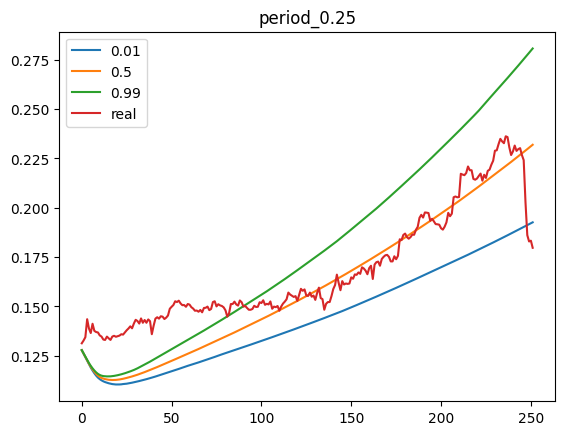

In [266]:
# for i in range(historical_data_validate.shape[1]):
i=0

sim_data = synthetic_samples[:, :, i] * std[i] - mean[i]
sim_data = pd.DataFrame(sim_data)
sim_data = np.exp(np.cumsum(sim_data.T, axis=0))
sim_data = historical_data_validate.iloc[0, i] * sim_data

sim_data.quantile([0.01, 0.5, 0.99], axis=1).T.plot()
plt.plot(historical_data_validate.iloc[1:, i].values, label="real")
plt.legend()
plt.title(historical_data_validate.columns[i])
plt.show()

<Axes: >

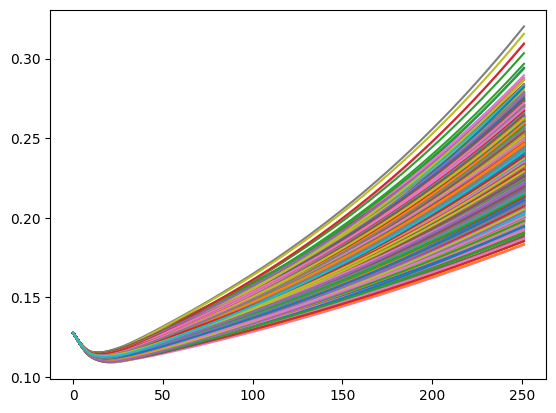

In [264]:
sim_data.plot(legend=False)